## Portfolio optimization using Genetic Algorithm 

### Problem Statement and Data used for the Problem:

   Suppose we have identified N financial assets that we wish to invest in, such as stocks, funds, bonds, or ETFs. Each asset has a historical return, which refers to the relative price difference between two periods, such as days, weeks, or months. Our objective is to construct an investment portfolio that comprises a mixture of several assets, and allocate a fraction x of total capital to each asset, which is known as the weight. The aim of portfolio optimization is to determine the optimal weights for each asset that maximizes returns and minimizes risk while adhering to certain constraints.
   
   #### Given Data:
Monthly Closing Stock values of MRF, Infosys, Reliance, Coal India, SBI and Titan from June 2015 to June 2018.

#### Theoretical Approach for the Problem used:


Firstly, the data for the monthly closing stock values of MRF, Infosys, Reliance, Coal India, SBI and Titan are combined into a single dataframe. Historical returns for different periods ranging from 3 months to 36 months are then calculated for each of the stocks. The next step is to define the genetic algorithm terms - Gene and Chromosome. Gene is a scalar, which represents a fraction of the total capital assigned to a stock, whereas a Chromosome is a 1D array consisting of a set of genes, i.e., fractions of total capital assigned to each stock. It is essential to ensure that the sum of each chromosome is equal to one.

After defining the Gene and Chromosome, the next step is to generate an Initial Population, which is a 2D array consisting of randomly generated chromosomes. The fitness function is then defined, which calculates the Sharpe ratio, S. The Sharpe ratio is a measure that quantifies the performance of the portfolio by maximizing return and minimizing risk simultaneously. It is computed as the difference between the portfolio return and the risk-free rate, divided by the standard deviation of the returns. The fitness function uses the mean portfolio return, risk-free rate, and the standard deviation of the portfolio return to calculate the Sharpe ratio.

In [ ]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

#### Combine the data into a single dataframe after reading it.

In [ ]:
files=['MRF.csv','INFOSYS.csv','RELIANCE.csv','COAL.csv','SBI.csv','TITAN.csv']
dfs=[]
for file in files:
    temp=pd.read_csv(file)
    temp.columns=['Date',file.replace('.csv','')]
    dfs.append(temp)
stocks = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
print(stocks.shape)
stocks.head()

#### Historical Returns for 3 months, 6 months, 12 months, 24 months and 36 months for each stock.

The calculation for the overall return of a stock involves adding the increase in its price with any dividends distributed and then dividing it by the initial price of the stock.


In [ ]:
def hist_return(months):
    idx=[]
    df=pd.DataFrame()
    for mon in months:
        temp=(stocks.iloc[0,1:] - stocks.iloc[mon,1:])/(stocks.iloc[mon,1:])
        idx.append(str(mon)+' Month Return ')
        df=pd.concat([df, temp.to_frame().T], ignore_index=True)
    df.index=idx
    return df    

hist_stock_returns=hist_return([3,6,12,24,36])
hist_stock_returns

Define **Gene** (Scalar): A fraction of the total capital assigned to a stock. Lets address them as weights.

In [ ]:
gene = np.random.rand()
gene

In [ ]:
import time
def gen_mc_grid(rows, cols, n, N):  
        np.random.seed(seed=int(time.time())) 
        layouts = np.zeros((n, rows * cols), dtype=np.int32)  
        positionX = np.random.randint(0, cols, size=(N * n * 2))
        positionY = np.random.randint(0, rows, size=(N * n * 2))
        ind_rows = 0  
        ind_pos = 0  
        while ind_rows < n:
            layouts[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols] = 1
            if np.sum(layouts[ind_rows, :]) == N:
                ind_rows += 1
            ind_pos += 1
            if ind_pos >= N * n * 2:
                break
        return layouts

def gen_mc_grid_with_NA_loc(rows, cols, n, N,NA_loc):  
        np.random.seed(seed=int(time.time()))  
        layouts = np.zeros((n, rows * cols), dtype=np.int32)  
        layouts_NA= np.zeros((n, rows * cols), dtype=np.int32)  
        for i in NA_loc:
            layouts_NA[:,i-1]=2
        positionX = np.random.randint(0, cols, size=(N * n * 2))
        positionY = np.random.randint(0, rows, size=(N * n * 2))
        ind_rows = 0  
        ind_pos = 0  
        N_count=0
        while ind_rows < n:
            cur_state=layouts_NA[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols]
            if cur_state!=1 and cur_state!=2:
                layouts[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols]=1
                layouts_NA[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols] = 1
                N_count+=1
                if np.sum(layouts[ind_rows, :]) == N:
                    ind_rows += 1
                    N_count=0
            ind_pos += 1
            if ind_pos >= N * n * 2:
                break
        return layouts,layouts_NA

Defining Chromosome (1D Array): Set of genes i.e. fractions of total capital assigned to each stock. Set of weights.

It is a 1D array consisting of fractional values representing each stock, with the sum of all fractions not exceeding 1. To create a chromosome, we will generate 6 fractional values, one for each company stock.

Why should the sum be equal to 1? This is because we assume that the total capital invested in the portfolio is 1 unit, and the fractional values represent the proportion of the total capital assigned to each stock.

To ensure that the sum equals 1, we can generate 6 random numbers and calculate a factor that is equal to 1 divided by the sum of these random numbers. Finally, we can multiply each of the generated random numbers with this factor, which will result in a sum of 1.

In [ ]:
def chromosome(n):
    ch = np.random.rand(n)
    return ch/sum(ch)

child=chromosome(6)
print(child)
print("Sum = ", sum(child))

Generating Initial Population


In [ ]:
n=6 
pop_size=100 

population = np.array([chromosome(n) for _ in range(pop_size)])
print(population.shape)

The fitness function is defined as the Sharpe ratio, which measures the performance of the portfolio. It is calculated using the following formula:

            S = (µ − r)/σ

where µ is the mean portfolio return over a specified period, r is the risk-free rate over the same period, and σ is the standard deviation of the returns over the specified period.

The mean portfolio return is calculated as the product of the mean return and the fractions of total capital assigned to each stock (chromosome).

The risk-free rate is set to 0.0697 (as per Google).

The standard deviation of the portfolio return is calculated as the square of the product of the chromosome and the standard deviation, plus the covariance of the respective weights in the chromosome.

Calculating Mean, Standard deviation and covariance of the Historical stock returns.

In [ ]:
cols=hist_stock_returns.columns
hist_stock_returns[cols] = hist_stock_returns[cols].apply(pd.to_numeric, errors='coerce')

Covariance of Returns

In [ ]:
cov_hist_return=hist_stock_returns.cov()
for i in range(6):
    cov_hist_return.iloc[i][i]=0
    
cov_hist_return

Mean of Returns

In [ ]:
mean_hist_return=hist_stock_returns.mean()
print (mean_hist_return)

Standard Deviation

In [ ]:
sd_hist_return=hist_stock_returns.std()
print (sd_hist_return)


Calculating Expected Portfolio Return and Portfolio Variance.

Expected Return

In [ ]:
def mean_portfolio_return(child):
    return np.sum(np.multiply(child,mean_hist_return))

print("Expected Return = ", + mean_portfolio_return(population[0]))

def var_portfolio_return(child):
    part_1 = np.sum(np.multiply(child,sd_hist_return)**2)
    temp_lst=[]
    for i in range(6):
        for j in range(6):
            temp=cov_hist_return.iloc[i][j] * child[i] * child[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2

print("Portfolio Variance = ", + var_portfolio_return(population[0]))

Fitness Function

In [ ]:
def fitness_fuction(child):
    rf= 0.0697 
    return (mean_portfolio_return(child)-rf)/np.sqrt(var_portfolio_return(child))

fitness_fuction(population[7])

Defining a function that selects the elite population: it filters out the chromosomes with the highest returns, which were previously calculated in the fitness function.

In [ ]:
def Select_elite_population(population, frac=0.3):
    population = sorted(population,key = lambda x: fitness_fuction(x),reverse=True)
    percentage_elite_idx = int(np.floor(len(population)* frac))
    return population[:percentage_elite_idx]

print(len(Select_elite_population(population, frac=0.3)))

[fitness_fuction(x) for x in population][:3]

The mutation function performs changes to a chromosome. It selects two random numbers between 0 and 5, and then swaps the corresponding elements in the chromosome.

In [ ]:
def mutation(parent):
    child=parent.copy()
    n=np.random.choice(range(6),2)
    while (n[0]==n[1]):
        n=np.random.choice(range(6),2)
    child[n[0]],child[n[1]]=child[n[1]],child[n[0]]
    return child

mutation(population[1]),population[1]

Crossover: The heuristic crossover, also known as blend crossover, uses the fitness values of two parent chromosomes to determine the direction of the search, moving from the worst parent to the best parent.

The offspring are generated using the following equation:

        Offspring A = Best Parent + β * (Best Parent − Worst Parent)
        Offspring B = Worst Parent - β * (Best Parent − Worst Parent)
        
Where β is a random number between 0 and 1. This type of crossover is effective for real-valued genomes.

In [ ]:
def Heuristic_crossover(parent1,parent2):
    ff1=fitness_fuction(parent1)
    ff2=fitness_fuction(parent2)
    diff=parent1 - parent2
    beta=np.random.rand()
    if ff1>ff2:
        child1=parent1 + beta * diff
        child2=parent2 - beta * diff
    else:
        child2=parent1 + beta * diff
        child1=parent2 - beta * diff
    return child1,child2

A function that creates a new generation of chromosomes by performing mutation, mating, or crossover based on a given probability.

In [ ]:
def next_generation(pop_size,elite,crossover=Heuristic_crossover):
    new_population=[]
    elite_range=range(len(elite))
    while len(new_population) < pop_size:
        if len(new_population) > 2*pop_size/3: 
            mutate_or_crossover = np.random.choice([0, 1], p=[0.9, 0.1])
        else:
            mutate_or_crossover = np.random.choice([0, 1], p=[0.6, 0.4])
        if mutate_or_crossover:
            indx=np.random.choice(elite_range)
            new_population.append(mutation(elite[indx]))
        else:
            p1_idx,p2_idx=np.random.choice(elite_range,2)
            c1,c2=crossover(elite[p1_idx],elite[p2_idx])
            chk=0
            for gene in range(6):
                if c1[gene]<0:
                    chk+=1
                else:
                    chk+=0
            if chk >0:
                p1_idx,p2_idx=np.random.choice(elite_range,2)
                c1,c2=crossover(elite[p1_idx],elite[p2_idx])
            new_population.extend([c1,c2])
    
    for i in range(len(new_population)):
        for j in range(6):
            if new_population[i][j] < 0:
                new_population[i][j] = 0
            if new_population[i][j] > 0.25:
                new_population[i][j] = 0.25

    for i in range(len(new_population)):
        temp = sum(new_population[i])
        for j in range(6):
            new_population[i][j] = new_population[i][j]/temp
    
    return new_population

elite=Select_elite_population(population)

The process of mutation, crossover, and selection of the next generation is repeated until there is no improvement in the maximum returns or minimum risk, or for a fixed number of iterations.

In [ ]:
n=6 
pop_size=100 
population = np.array([chromosome(n) for _ in range(pop_size)])

elite = Select_elite_population(population)

iteration=0 
Expected_returns=0
Expected_risk=1

returns_list = []
risk_list = []

while ( (Expected_returns < 0.30 and Expected_risk > 0.0005) or iteration <= 100 ):
    print('Iteration:',iteration)
    population = next_generation(100,elite)
    elite = Select_elite_population(population)
    Expected_returns=mean_portfolio_return(elite[0])
    Expected_risk=var_portfolio_return(elite[0])
    print('Expected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))
    iteration+=1
    returns_list.append(Expected_returns)
    risk_list.append(Expected_risk)

print('Optimal Solution Reached or Number of Maximum Iterations Reached')

Weights and their Returns:

In [ ]:
print('Weight allotted to each stock under the constraints applied:\n')
[print(hist_stock_returns.columns[i],':',elite[0][i]) for i in list(range(6))]

print('\nExpected returns of {} % with risk of {}\n '.format(Expected_returns*100,Expected_risk))

print("Fitness Function Value = ", + fitness_fuction(elite[5]))

plt.figure(figsize = (10,10))
plt.pie(elite[0], labels = hist_stock_returns.columns)
plt.legend()
plt.show()

plt.scatter(risk_list, returns_list)
plt.ylabel('Expected Returns')
plt.xlabel('Expected Risk')
plt.title('Portfolio Optimization')
plt.show()

The given process involves the creation of two offspring, represented as one-dimensional arrays, from two parent arrays. The offspring arrays are created using the following equations:

- Offspring A = α * Parent1 + (1 - α) * Parent2

- Offspring B = (1 - α) * Parent1 + α * Parent2

Here, the value of α is a randomly generated number between 0 and 1. The input to this process is two parent arrays, and the output is two offspring arrays, each represented as a one-dimensional array.

In [ ]:
def Arithmetic_crossover(parent1,parent2):
    alpha = np.random.rand()
    child1 = alpha * parent1 + (1-alpha) * parent2
    child2 = (1-alpha) * parent1 + alpha * parent2
    return child1,child2

In [ ]:
Arithmetic_crossover(population[2],population[3])
elite=Select_elite_population(population)
next_generation(100,elite,Arithmetic_crossover)[:3]
       

In [ ]:
n=6 
pop_size=100 
population = np.array([chromosome(n) for _ in range(pop_size)])
elite = Select_elite_population(population)

iteration=0 
Expected_returns=0
Expected_risk=1

returns_list = []
risk_list = []

while ( (Expected_returns < 0.30 and Expected_risk > 0.0005) and iteration <= 100 ):
    print('Iteration:',iteration)
    population = next_generation(100,elite, Arithmetic_crossover)
    elite = Select_elite_population(population)
    Expected_returns=mean_portfolio_return(elite[0])
    Expected_risk=var_portfolio_return(elite[0])
    print('Expected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))
    iteration+=1
    returns_list.append(Expected_returns)
    risk_list.append(Expected_risk)


print('Optimal Solution Reached or Number of Maximum Iterations Reached')

In [ ]:
print('Weight allotted to each stock under the constraints applied:\n')
[print(hist_stock_returns.columns[i],':',elite[0][i]) for i in list(range(6))]

print('\nExpected returns of {} % with risk of {}\n '.format(Expected_returns*100,Expected_risk))

print("Fitness Function Value = ", + fitness_fuction(elite[5]))

plt.figure(figsize = (10,10))
plt.pie(elite[0], labels = hist_stock_returns.columns)
plt.legend()
plt.show()

plt.scatter(risk_list, returns_list)
plt.ylabel('Expected Returns')
plt.xlabel('Expected Risk')
plt.title('Portfolio Optimization')
plt.show()

Portfolio Expected Return: 8.833333333333334


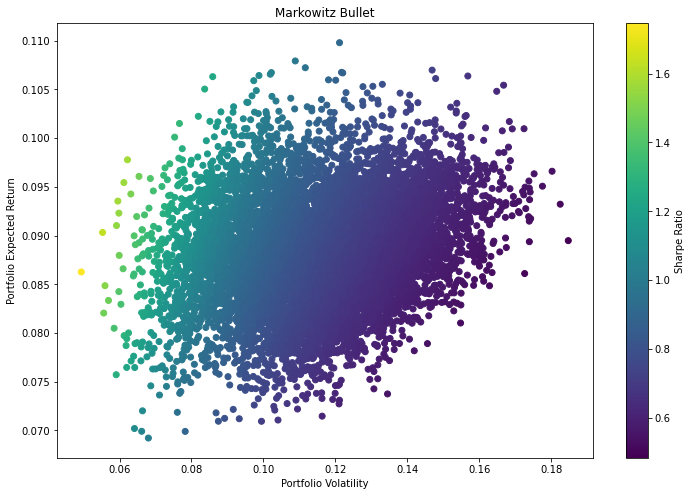

In [30]:
covariance = np.array([[0.000000, 0.045393, 0.027916, 0.024127, -0.079078, 0.014362],
                      [0.045393, 0.000000, -0.000718, 0.004381, -0.023178, -0.005554],
                      [0.027916, -0.000718, 0.000000, 0.002510, -0.013841, 0.007330],
                      [0.024127, 0.004381, 0.002510, 0.000000, -0.011042, 0.005700],
                      [-0.079078, -0.023178, -0.013841, -0.011042, 0.000000, -0.007211],
                      [0.014362, -0.005554, 0.007330, 0.005700, -0.007211, 0.000000]])

expected_returns = np.array([0.08, 0.12, 0.06, 0.09, 0.11, 0.07])
portfolio_weights = np.ones(len(expected_returns))/len(expected_returns)
portfolio_return = np.dot(expected_returns, portfolio_weights)
portfolio_variance = np.dot(np.dot(portfolio_weights, covariance), portfolio_weights)

print("Portfolio Expected Return:", portfolio_return*100)

num_portfolios = 10000
portfolio_returns = np.zeros(num_portfolios)
portfolio_variances = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    
    portfolio_returns[i] = np.dot(expected_returns, weights)
    portfolio_variances[i] = np.sqrt(np.dot(np.dot((weights), abs(covariance)), (weights)))
    
plt.figure(figsize=(12,8))
plt.scatter(portfolio_variances, portfolio_returns, c=portfolio_returns/portfolio_variances)
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Markowitz Bullet')
plt.show()
